In [1]:
from google.colab import drive 
drive.mount('/content/drive')
%cd drive/Shareddrives/CS263\ Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/CS263 Project


In [2]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
import re
import numpy as np
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
!pip3 install openai
import openai
!pip install tensorflow-hub
import tensorflow_hub as hub
!pip install --upgrade simple_elmo
!pip install pyarrow

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


###preprocess text:

In [5]:
texts = []
labels = []
for i, row in df.iterrows():
  labels.append(row['v1'])
  texts.append(row['v2'])

In [6]:
max = 0
for t in texts:
  if len(t.split()) > max:
    max = len(t.split())
print(max)

171


In [7]:
def clean(text):
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        texter = re.sub(r"<br />", " ", text)
        texter = re.sub(r"&quot;", "\"",texter)
        texter = re.sub('&#39;', "\"", texter)
        texter = re.sub('\n', " ", texter)
        texter = re.sub(' u '," you ", texter)
        texter = re.sub('`',"", texter)
        texter = re.sub(' +', ' ', texter)
        texter = re.sub(r"(!)\1+", r"!", texter)
        texter = re.sub(r"(\?)\1+", r"?", texter)
        texter = re.sub('&amp;', 'and', texter)
        texter = re.sub('\r', ' ',texter)
        clean = re.compile('<.*?>')
        texter = texter.encode('ascii', 'ignore').decode('ascii')
        texter = re.sub(clean, '', texter)
        if texter == "":
            texter = ""
        return texter

def remove_nums(text):
    cleaned = []
    terms = text.split(' ')
    for term in terms:
        num_digits = 0
        for i in term:
            if i.isdigit():
                num_digits += 1
        if num_digits == 0:
            cleaned.append(term)
    return ' '.join(cleaned)

df_cleaned = []
for text in df.v2:
    cleaned = clean(text)
    cleaned = remove_nums(cleaned)
    df_cleaned.append(cleaned)
df['cleaned'] = df_cleaned

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        # since default is noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()
df_tokenized = []
for text in df['cleaned']:
    df_tokenized.append(word_tokenize(text))
df['tokenized'] = df_tokenized
df_tagged = []
for tokens in df['tokenized']:
    df_tagged.append(nltk.pos_tag(tokens))
df['tagged'] = df_tagged
df_lemmatized = []
stops = stopwords.words('english')
for tagged in df_tagged:
    lemma_doc = []
    for pair in tagged:
        lemma_term = lemmatizer.lemmatize(pair[0],pos_tagger(pair[1]))
        if lemma_term not in stops and lemma_term not in [',','.',';','?','!']:
            lemma_doc.append(lemma_term)
    #df_lemmatized.append(' '.join(lemma_doc))
    df_lemmatized.append(lemma_doc)
df['compressed'] = df_lemmatized


In [8]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,cleaned,tokenized,tagged,compressed
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","[(Go, NNP), (until, IN), (jurong, JJ), (point,...","[Go, jurong, point, crazy, .., Available, bugi..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif you oni...,"[Ok, lar, ..., Joking, wif, you, oni, ...]","[(Ok, NNP), (lar, NN), (..., :), (Joking, VBG)...","[Ok, lar, ..., Joking, wif, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in a wkly comp to win FA Cup final ...,"[Free, entry, in, a, wkly, comp, to, win, FA, ...","[(Free, JJ), (entry, NN), (in, IN), (a, DT), (...","[Free, entry, wkly, comp, win, FA, Cup, final,..."
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[(U, JJ), (dun, NNS), (say, VBP), (so, RB), (e...","[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[(Nah, NNP), (I, PRP), (do, VBP), (n't, RB), (...","[Nah, I, n't, think, go, usf, live, around, th..."
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN,This is the time we have tried contact u. U ha...,"[This, is, the, time, we, have, tried, contact...","[(This, DT), (is, VBZ), (the, DT), (time, NN),...","[This, time, try, contact, u., U, win, Pound, ..."
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN,Will _ b going to esplanade fr home?,"[Will, _, b, going, to, esplanade, fr, home, ?]","[(Will, MD), (_, VB), (b, NN), (going, VBG), (...","[Will, _, b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN,"Pity, * was in mood for that. So...any other s...","[Pity, ,, *, was, in, mood, for, that, ., So, ...","[(Pity, NN), (,, ,), (*, NN), (was, VBD), (in,...","[Pity, *, mood, So, ..., suggestion]"
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN,The guy did some bitching but I acted like i'd...,"[The, guy, did, some, bitching, but, I, acted,...","[(The, DT), (guy, NN), (did, VBD), (some, DT),...","[The, guy, bitching, I, act, like, 'd, interes..."


###GloVe with preprocessing:

In [26]:
max_len_terms = 0
for doc in df['compressed']:
    if len(doc) > max_len_terms:
        max_len_terms = len(doc)
len_df = len(df)
print('max length of terms: ' + str(max_len_terms))
print('number of documents: ' + str(len_df))

max length of terms: 134
number of documents: 5572


In [27]:
embeddings_dict = {}
dimension_of_glove = 50
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [28]:
glove_rep_list = []
for lemma_list in df['compressed']:
    glove_rep = np.zeros((max_len_terms, dimension_of_glove))
    for i, word in enumerate(lemma_list):
        lc_word = word.lower()
        if lc_word in embeddings_dict:
            vec = embeddings_dict[lc_word]
            glove_rep[i] = vec
    glove_rep_list.append(glove_rep)
df['glove_rep'] = glove_rep_list

In [29]:
train, test = train_test_split(df[["glove_rep", "v1"]], test_size=0.2)

train_labels = []
for label in train.v1:
    if label == 'spam':
        train_labels.append(1)
    else:
        train_labels.append(0)

test_labels = []
for label in test.v1:
    if label == 'spam':
        test_labels.append(1)
    else:
        test_labels.append(0)

In [30]:
clf = MLPClassifier()
clf.output_activation_ = 'softmax'

In [31]:
tgr_reshape=[]
for rep in train['glove_rep']:
    x_dim, y_dim = rep.shape
    reshaped = rep.reshape(x_dim*y_dim)
    tgr_reshape.append(reshaped)
clf.fit(tgr_reshape, train_labels)

MLPClassifier()

In [32]:
test_gr_reshape=[]
for rep in test['glove_rep']:
    x_dim, y_dim = rep.shape
    reshaped = rep.reshape(x_dim*y_dim)
    test_gr_reshape.append(reshaped)
test_pred = clf.predict(test_gr_reshape)

In [33]:
print('f1 score: ' + str(f1_score(test_labels, test_pred)))
print('precision score: ' + str(precision_score(test_labels, test_pred)))
print('accuracy score: ' + str(accuracy_score(test_labels, test_pred)))
print('recall score: ' + str(recall_score(test_labels, test_pred)))

f1 score: 0.8620689655172414
precision score: 0.9124087591240876
accuracy score: 0.9641255605381166
recall score: 0.8169934640522876


###Cells used for metrics with keras:

From [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics)

In [9]:
METRICS = [
      'accuracy',
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [10]:
def f1_from_history(history, validation=False):
  f1_scores = []
  for i in range(len(history.history['precision'])):
    if not validation:
      p = history.history['precision'][i]
      r = history.history['recall'][i]
    else:
      p = history.history['val_precision'][i]
      r = history.history['val_recall'][i]
    f1 = 2/(1/p + 1/r)
    f1_scores.append(f1)

  return f1_scores

def make_2x2_metrics_plot(history, fig_title):
  x = np.linspace(1,5,5)
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_prec = history.history['precision']
  val_prec = history.history['val_precision']
  train_rec = history.history['recall']
  val_rec = history.history['val_recall']
  train_f1 = f1_from_history(history)
  val_f1 = f1_from_history(history,True)

  fig, axs = plt.subplots(2,2,figsize=(10,6))
  axs[0,0].plot(x, train_acc, label='Train Accuracy')
  axs[0,0].plot(x, val_acc, label='Test Accuracy')
  axs[0,0].set_title('Accuracy')
  axs[0,0].legend()

  axs[0,1].plot(x, train_prec, label='Train Precision')
  axs[0,1].plot(x, val_prec, label='Test Precision')
  axs[0,1].set_title('Precision')
  axs[0,1].legend()

  axs[1,0].plot(x, train_rec, label='Train Recall')
  axs[1,0].plot(x, val_rec, label = 'Test Recall')
  axs[1,0].set_title('Recall')
  axs[1,0].legend()

  axs[1,1].plot(x, train_f1, label='Train F1 Score')
  axs[1,1].plot(x, val_f1, label='Test F1 Score')
  axs[1,1].set_title('F1 Score')
  axs[1,1].legend()

  fig.suptitle(fig_title)
  plt.tight_layout()
  plt.show()

###Fixed Window with TensorFlow:

In [21]:
# Set the input and output dimensions
vocab_size = 10085
output_dim = 1

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=200))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=METRICS)

In [86]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 128)          1290880   
                                                                 
 flatten_3 (Flatten)         (None, 25600)             0         
                                                                 
 dense_15 (Dense)            (None, 1)                 25601     
                                                                 
Total params: 1,316,481
Trainable params: 1,316,481
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Train the model
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/5
140/140 [==============================] - 3s 13ms/step - loss: 0.2591 - accuracy: 0.9055 - tp: 313.0000 - fp: 40.0000 - tn: 4785.0000 - fn: 434.0000 - precision: 0.8867 - recall: 0.4190 - auc: 0.9037 - prc: 0.7109 - val_loss: 0.0896 - val_accuracy: 0.9785 - val_tp: 120.0000 - val_fp: 6.0000 - val_tn: 971.0000 - val_fn: 18.0000 - val_precision: 0.9524 - val_recall: 0.8696 - val_auc: 0.9896 - val_prc: 0.9595
Epoch 2/5
140/140 [==============================] - 1s 10ms/step - loss: 0.0537 - accuracy: 0.9850 - tp: 545.0000 - fp: 3.0000 - tn: 3845.0000 - fn: 64.0000 - precision: 0.9945 - recall: 0.8949 - auc: 0.9952 - prc: 0.9844 - val_loss: 0.0517 - val_accuracy: 0.9857 - val_tp: 125.0000 - val_fp: 3.0000 - val_tn: 974.0000 - val_fn: 13.0000 - val_precision: 0.9766 - val_recall: 0.9058 - val_auc: 0.9947 - val_prc: 0.9820
Epoch 3/5
140/140 [==============================] - 1s 10ms/step - loss: 0.0226 - accuracy: 0.9944 - tp: 584.0000 - fp: 0.0000e+00 - tn: 3848.0000 - fn: 25.000

In [58]:
preds_nn = model.predict(x_test)

35/35 [==============================] - 0s 1ms/step


In [59]:
y_pred_nn = []
for pred in preds_nn:
  if pred > 0.5:
    y_pred_nn.append(1)
  else:
    y_pred_nn.append(0)

In [65]:
print('f1 score: ' + str(f1_score(y_test, y_pred_nn)))
print('precision score: ' + str(precision_score(y_test, y_pred_nn)))
print('accuracy score: ' + str(accuracy_score(y_test, y_pred_nn)))
print('recall score: ' + str(recall_score(y_test, y_pred_nn)))

f1 score: 0.9389312977099237
precision score: 0.9919354838709677
accuracy score: 0.9856502242152466
recall score: 0.8913043478260869


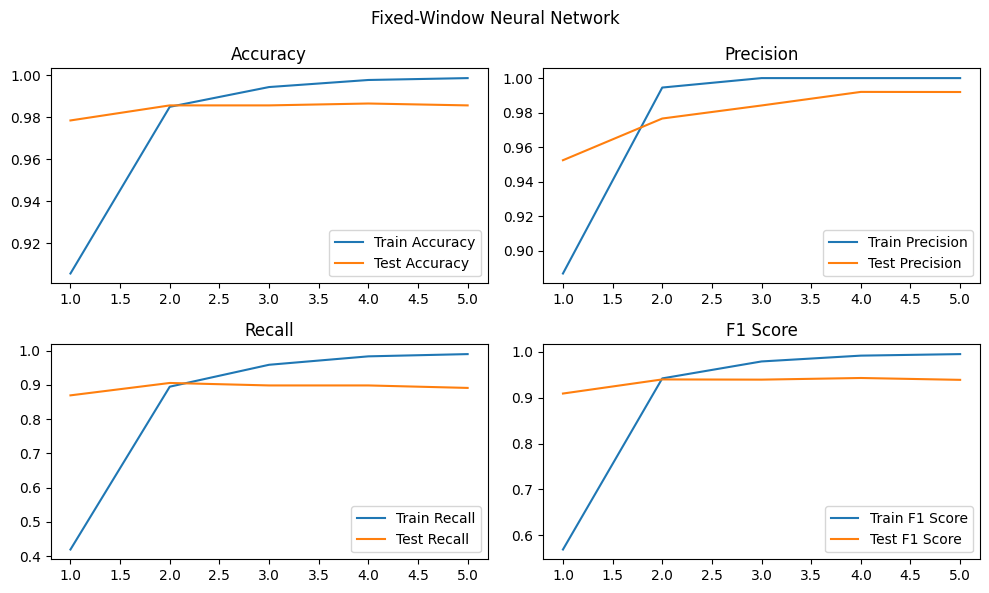

In [74]:
make_2x2_metrics_plot(history, 'Fixed-Window Neural Network')

###Bi-directional RNN:

Following this guide for creating a bidirectional RNN:
https://www.scaler.com/topics/deep-learning/bidirectional-rnn/

Look at the data used in the guide:

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [19]:
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [19]:
type(x_train)

numpy.ndarray

In [20]:
type(x_train[0])

list

In [21]:
type(x_train[0][0])

int

In [22]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

Use a vocabulary map to make a list of vocab indices like the above data:

In [10]:
vocab_dict = {}
index = 0
for tokens in df['tokenized']:
  for token in tokens:
    if token not in vocab_dict:
      vocab_dict[token] = index
      index += 1

In [11]:
vocab_mapped = []
for tokens in df['tokenized']:
  vocab_map = []
  for token in tokens:
    vocab_map.append(vocab_dict[token])
  vocab_mapped.append(vocab_map)
df['vocab_mapped'] = vocab_mapped

In [12]:
train, test = train_test_split(df[["vocab_mapped", "v1"]], test_size=0.2)

train_labels = []
for label in train.v1:
    if label == 'spam':
        train_labels.append(1)
    else:
        train_labels.append(0)

test_labels = []
for label in test.v1:
    if label == 'spam':
        test_labels.append(1)
    else:
        test_labels.append(0)

In [24]:
x_train = train['vocab_mapped']
y_train = train_labels
x_test = test['vocab_mapped']
y_test = test_labels
y_train = np.asarray(train_labels).astype('int32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('int32').reshape((-1,1))

In [26]:
len(x_train)

4457

In [28]:
max_len = 0
for text in df['v2']:
  if len(text.split()) > max_len:
    max_len = len(text.split())

In [29]:
max_len

171

In [30]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [31]:
x_test.shape

(1115, 171)

In [42]:
len(vocab_dict)

10085

In [77]:
# Set the input and output dimensions
vocab_size = len(vocab_dict)
output_dim = 1
# Create the input layer
inputs = tf.keras.Input(shape=(None,), dtype="int32")

# Create the model
x = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(100, return_sequences=False))(x)
outputs = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile("adam", "binary_crossentropy", metrics=METRICS)

In [78]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 128)         1290880   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              45800     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,336,881
Trainable params: 1,336,881
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Train the model
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/5
140/140 [==============================] - 18s 113ms/step - loss: 0.3710 - accuracy: 0.8636 - tp: 126.0000 - fp: 4.0000 - tn: 4821.0000 - fn: 621.0000 - precision: 0.9692 - recall: 0.1687 - auc: 0.7887 - prc: 0.4761 - val_loss: 0.2814 - val_accuracy: 0.8780 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 973.0000 - val_fn: 132.0000 - val_precision: 0.6000 - val_recall: 0.0435 - val_auc: 0.8793 - val_prc: 0.6253
Epoch 2/5
140/140 [==============================] - 15s 108ms/step - loss: 0.1436 - accuracy: 0.9493 - tp: 401.0000 - fp: 18.0000 - tn: 3830.0000 - fn: 208.0000 - precision: 0.9570 - recall: 0.6585 - auc: 0.9692 - prc: 0.9162 - val_loss: 0.0674 - val_accuracy: 0.9803 - val_tp: 124.0000 - val_fp: 8.0000 - val_tn: 969.0000 - val_fn: 14.0000 - val_precision: 0.9394 - val_recall: 0.8986 - val_auc: 0.9901 - val_prc: 0.9662
Epoch 3/5
140/140 [==============================] - 15s 108ms/step - loss: 0.0266 - accuracy: 0.9928 - tp: 582.0000 - fp: 5.0000 - tn: 3843.0000 - fn: 27.0

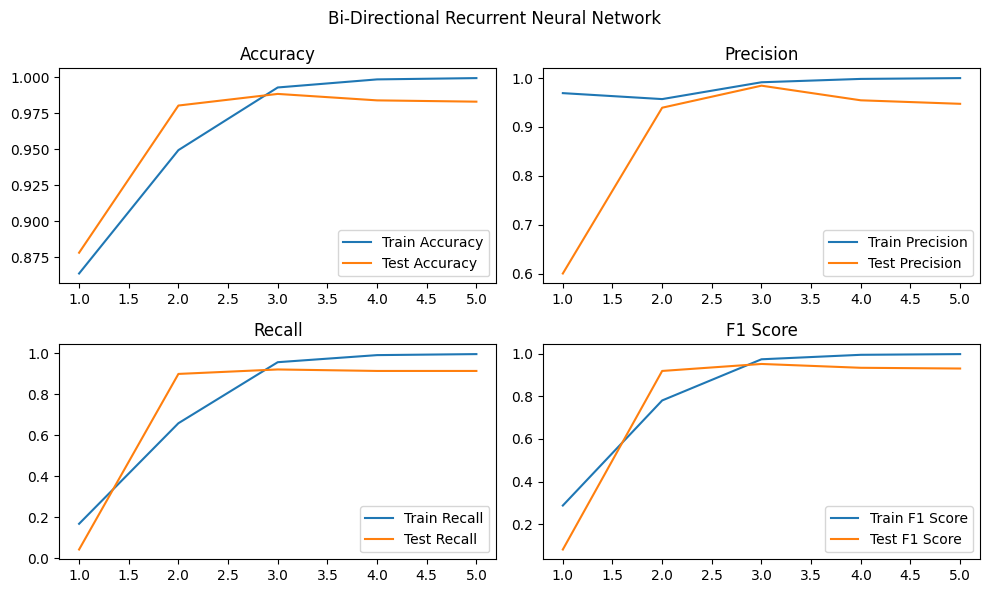

In [80]:
make_2x2_metrics_plot(history, 'Bi-Directional Recurrent Neural Network')

###ELMO Transfer Learning:

In [3]:
from simple_elmo import ElmoModel

In [4]:
model = ElmoModel()
model.load('./elmo_weights')

/usr/local/lib/python3.10/dist-packages/simple_elmo/model.py:531: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
/usr/local/lib/python3.10/dist-packages/simple_elmo/model.py:531: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
/usr/local/lib/python3.10/dist-packages/simple_elmo/model.py:531: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(


'The model is now loaded.'

In [15]:
df['elmo_texts'] = [x.split() for x in df['v2']]

In [35]:
df.to_parquet('elmo_preprocessing.pqt')

In [5]:
df = pd.read_parquet('elmo_preprocessing.pqt')

In [6]:
elmo_reps = model.get_elmo_vectors(df['elmo_texts'].tolist(), layers="top")

In [18]:
elmo_rep_list = []
for i in range(len(elmo_reps)):
  elmo_rep_list.append(elmo_reps[i])
df['elmo_rep'] = elmo_rep_list

In [11]:
train, test = train_test_split(df[["elmo_rep", "v1"]], test_size=0.2)

train_labels = []
for label in train.v1:
    if label == 'spam':
        train_labels.append(1)
    else:
        train_labels.append(0)

test_labels = []
for label in test.v1:
    if label == 'spam':
        test_labels.append(1)
    else:
        test_labels.append(0)

In [19]:
clf = MLPClassifier()
clf.output_activation_ = 'softmax'

In [21]:
train_er_reshape=[]
for rep in train['elmo_rep']:
    x_dim, y_dim = rep.shape
    reshaped = rep.reshape(x_dim*y_dim)
    train_er_reshape.append(reshaped)
clf.fit(train_er_reshape, train_labels)

MLPClassifier()

In [24]:
test_er_reshape=[]
for rep in test['elmo_rep']:
    x_dim, y_dim = rep.shape
    reshaped = rep.reshape(x_dim*y_dim)
    test_er_reshape.append(reshaped)
test_pred = clf.predict(test_er_reshape)

In [25]:
print('f1 score: ' + str(f1_score(test_labels, test_pred)))
print('precision score: ' + str(precision_score(test_labels, test_pred)))
print('accuracy score: ' + str(accuracy_score(test_labels, test_pred)))
print('recall score: ' + str(recall_score(test_labels, test_pred)))

f1 score: 0.9357798165137615
precision score: 0.95625
accuracy score: 0.9811659192825112
recall score: 0.9161676646706587
